# Imports, data class and other helping methods

In [8]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from IPython.display import clear_output

In [9]:
# Now offers a shitty way to encode months
#
# Loads and prepares the data.
# Data can be accessed over class variables: train_input_FOCI, train_target_FOCI, validation_input_FOCI...
# Unprocessed data is saved. When seq_length or feature_list are None, they are not used.
# Data is processed to have 0 mean and 1 std.
# possible_features variable contains list with all feature names, even those that have not been selected.
# For lead_time = 0, the sequences currently DO NOT contain previous prec_sahel values.
# flatten_seq = False means that each sample consits of the arrays for each time step (e.g. [t1, t2, ...])
# flatten_seq = True means that each sample contains all the values of the time steps. (array containing values vs array containing arrays of values)
# month_encoding one of ['normal', 'one_hot', 'one_hot_scaled']
class Data:
  # Split = [train,validation, test], lead_time >= 0, seq_length > 0 or None, feature_list None or list of feature names
  def __init__(self, split = [0.8, 0.1, 0.1], lead_time = 0, seq_length=None, flatten_seq=False, feature_list=None, month_encoding='normal'):
    # Variables
    self.scale_one_hot = False
    self.possible_features = [] # Filled later on to track all possible features before selection
    self.current_features = [] # Filled later to track selected features
    self.one_hot_column_names = [] # Filled later if one_hot_encode_months is set to true
    self.__data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
    )
    
    # Set variables for month encoding setting
    if month_encoding == 'normal':
        one_hot_encode_months = False
    elif month_encoding == 'one_hot':
        one_hot_encode_months = True
    elif month_encoding == 'one_hot_scaled':
        one_hot_encode_months = True
        self.scale_one_hot = True
    else:
        raise ValueError("month_encoding has to be one of: {} but was {}".format(['normal', 'one_hot', 'one_hot_scaled'], month_encoding))

    # Load the data
    FOCI, CESM = self.__load_data()
    
    # Get one_hot encodings for months and then remove the month column then join them back together
    # The one hot encoded columns will be normalised later.
    if one_hot_encode_months:
      one_hot_FOCI = pd.get_dummies(FOCI['month'], prefix='month')
      one_hot_CESM = pd.get_dummies(CESM['month'], prefix='month')
      self.one_hot_column_names = list(one_hot_FOCI.columns)  # Save one hot encoded column names to exclude from standarisation
      FOCI = one_hot_FOCI.join(FOCI.drop('month',axis = 1))
      CESM = one_hot_CESM.join(CESM.drop('month',axis = 1))


    # Split into input and target
    input_FOCI, target_FOCI = self.__get_input_target(FOCI, lead_time)
    input_CESM, target_CESM = self.__get_input_target(CESM, lead_time)

    # Save possible features that can be selected
    self.possible_features = list(input_FOCI.columns)

    # Select features if any are set
    input_FOCI = input_FOCI if feature_list is None else input_FOCI[feature_list]
    input_CESM = input_CESM if feature_list is None else input_CESM[feature_list]

    # Save selected features
    self.current_features = list(input_FOCI.columns)

    # Split into train, validation and test, based on split percentage given
    self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI = self.__get_train_validation_test(input_FOCI, split)
    self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI = self.__get_train_validation_test(target_FOCI, split)

    self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM = self.__get_train_validation_test(input_CESM, split)
    self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM = self.__get_train_validation_test(target_CESM, split)

    # Fit standardscaler on trainings data and then scale train, validation and test input with it to obtain 0 mean and 1 std
    # Returned values are numpy arrays
    self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI = self.__scale_data(self.train_input_FOCI, self.validation_input_FOCI, self.test_input_FOCI)
    self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM = self.__scale_data(self.train_input_CESM, self.validation_input_CESM, self.test_input_CESM)

    # Do the same with the target data
    self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI = self.__scale_data(self.train_target_FOCI, self.validation_target_FOCI, self.test_target_FOCI)
    self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM = self.__scale_data(self.train_target_CESM, self.validation_target_CESM, self.test_target_CESM)

    # Turn target arrays into 1D arrays, reshape only if array actually exists
    # otherwise an error would be thrown.
    if len(self.train_target_FOCI) > 0:
      self.train_target_FOCI = self.train_target_FOCI.reshape(-1)
      self.train_target_CESM = self.train_target_CESM.reshape(-1)
    if len(self.validation_target_FOCI) > 0:
      self.validation_target_FOCI = self.validation_target_FOCI.reshape(-1)
      self.validation_target_CESM = self.validation_target_CESM.reshape(-1)
    if len(self.test_target_FOCI) > 0:
      self.test_target_FOCI = self.test_target_FOCI.reshape(-1)
      self.test_target_CESM = self.test_target_CESM.reshape(-1)

    # Turn data into sequences consisting of seq_length timesteps
    if seq_length is not None:
      # Check for valid seq_length
      if seq_length <= 0:
        raise ValueError('seq_length has to be an integer > 0 or None but is{}'.format(seq_length))

      # Train FOCI
      if len(self.train_input_FOCI) > 0:
        self.train_input_FOCI, self.train_target_FOCI = self.__into_sequence(self.train_input_FOCI, self.train_target_FOCI, seq_length, flatten_seq)
      # Validation FOCI
      if len(self.validation_input_FOCI) > 0:
        self.validation_input_FOCI, self.validation_target_FOCI = self.__into_sequence(self.validation_input_FOCI, self.validation_target_FOCI, seq_length, flatten_seq)
      # Test FOCI
      if len(self.test_input_FOCI) > 0:
        self.test_input_FOCI, self.test_target_FOCI = self.__into_sequence(self.test_input_FOCI, self.test_target_FOCI, seq_length, flatten_seq)
      # Train CESM
      if len(self.train_input_CESM) > 0:
        self.train_input_CESM, self.train_target_CESM = self.__into_sequence(self.train_input_CESM, self.train_target_CESM, seq_length, flatten_seq)
      # Validation CESM
      if len(self.validation_input_CESM) > 0:
        self.validation_input_CESM, self.validation_target_CESM = self.__into_sequence(self.validation_input_CESM, self.validation_target_CESM, seq_length, flatten_seq)
      # Test CESM
      if len(self.test_input_CESM) > 0:
        self.test_input_CESM, self.test_target_CESM = self.__into_sequence(self.test_input_CESM, self.test_target_CESM, seq_length, flatten_seq)


  # Loads the data from url or disk, returns FOCI, CESM as pandas dataframes.
  def __load_data(self):

    # Check if data exists on disk, if so load from disk, otherwise from url
    if os.path.exists('C:\\Users\\Jannik\\climate_indices.csv'):
      climind = pd.read_csv('C:\\Users\\Jannik\\climate_indices.csv')
    else:
      climind = pd.read_csv(self.__data_url)
      # Save data to disk
      climind.to_csv('C:\\Users\\Jannik\\climate_indices.csv', index=False)

    # Split into FOCI and CESM and drop year
    climind = climind.set_index(["model", "year", "month", "index"]).unstack(level=-1)["value"]
    FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year'])
    CESM = climind.loc[('CESM')].reset_index().drop(columns=['year'])

    # Return them
    return FOCI, CESM

  # Takes the FOCI or CESM pandas dataframe and returns the input and target
  # Input and target depends on the lead_time, for lead_time >0 input contains
  # PREC_SAHEL of the current time step, for lead_time = 0 it does not.
  # lead_time determines how many months in advance the target is.
  def __get_input_target(self, data, lead_time):
    # Check if lead_time is vlaid
    if lead_time < 0:
      raise ValueError('lead_time has to have a value >= 0 but has value {}'.format(self.__lead_time))

    # Split into target and input, input has to omit the last lead_time elements or there would be no target for them
    target = data.loc[:,data.columns == 'PREC_SAHEL']
    input = data.loc[:,data.columns != 'PREC_SAHEL'] if lead_time == 0 else data[:-lead_time]

    # Adjust target for lead_time if needed
    if lead_time > 0:
      target = target[lead_time:]

    # Return input and target
    return input, target

  # Splits data based on the given split into train, validation and test
  # split = [train, validation, test] as decimal indicating percentage
  def __get_train_validation_test(self, data, split):
    # Check if split is valid
    if sum(split) != 1 or split[0] <= 0 or any(i < 0 for i in split):
      raise ValueError('Invalid split has been passed. Values can be negative, have to sum up to 1 and train has to be > 0')

    # Get number of samples for each split
    n_train = int(split[0] * len(data))
    n_val = int(split[1] * len(data))
    n_test = int(split[2] * len(data))  # Only used to check if there is a test set

    # Create the splits
    train = data[:n_train] if n_train > 0 else []
    val =  data[n_train:n_train+n_val] if n_val > 0 else []
    test = data[n_train+n_val:] if n_test > 0 else []

    # Return them
    return train, val, test

  # Scales the data so that the resulting data has mean of 0 and std of 1
  def __scale_data(self, train, val, test):
    scaler = None

    # If scale_one_hot is set to false exclude the one hot encoded columns before using the Standardscaler
    if self.scale_one_hot:
      scaler = StandardScaler()
    # Otherwise also scale them
    else:
      features = [feature_name for feature_name in train.columns if feature_name not in self.one_hot_column_names]
      scaler = ColumnTransformer([('normal features', StandardScaler(), features)], remainder='passthrough')

    # Fit on train data
    scaler.fit(train)

    # Transform train, val, test sets if they are non empty
    scaled_train = scaler.transform(train) if len(train) > 0 else []
    scaled_val = scaler.transform(val) if len(val) > 0 else []
    scaled_test = scaler.transform(test) if len(test) > 0 else []

    return scaled_train, scaled_val, scaled_test

  # Turns input into a sequence consisting of seq_length time steps
  # and selects i+seq_length-1 as the corresponding target index for the i'th sequence.
  def __into_sequence(self, input, target, seq_length, flatten_seq):
    input_seq = np.array([input[i:i+seq_length] for i in range(len(input)-seq_length)])
    target_seq = np.array([target[i+seq_length-1] for i in range(len(target)-seq_length)])

    # Flatten sample containing the sequences if wanted (sample = [t_0, t_1,...] with t_0 = [feature_1, feature_2,...])
    if flatten_seq:
      input_seq = [seq.reshape(-1) for seq in input_seq]

    return input_seq, target_seq

# Adaboost

In [10]:
# Settings for inital grid search
param_grid_ab = {
    'random_state': [1],
    'n_estimators': [50, 100, 150, 200],  # Number of estimators
    'learning_rate': [0.1, 0.5, 1.0]  # Learning rate
}

# Left out for now: max_features, max_samples

lead_time = 1
seq_length = 12 # 18

In [11]:
# Create data, Adaboost and GridSearchCV
data = Data(split=[0.9, 0 , 0.1], flatten_seq=True, seq_length=seq_length, lead_time=1)
ada = AdaBoostRegressor()
grid_search_ada = GridSearchCV(ada, param_grid_ab, cv=5, scoring='neg_mean_squared_error')

# Perform Gridsearch
grid_search_ada.fit(data.train_input_FOCI, data.train_target_FOCI)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 150, 200],
                         'random_state': [1]},
             scoring='neg_mean_squared_error')

In [12]:
# Print best settings and best (negative) mse
best_settings = grid_search_ada.best_params_
print('best settings: {}'.format(best_settings))
print('neg_mean_squared_error: {}'.format(grid_search_ada.best_score_))

best settings: {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 1}
neg_mean_squared_error: -0.9576418534321756


# Determine sequence length

In [66]:
def determine_seq_length(lead_time, settings, seq_lenghts):
    best_length = None
    best_corr = float('-inf')
    
    for seq in seq_lenghts:
        data = Data(lead_time=lead_time, seq_length=seq, flatten_seq=True)
        ada = AdaBoostRegressor(**best_settings)
        _, corr_foci = train_and_evaluate_randomforest(ada, data, calc_with='test', dataset='FOCI')
        
        if corr_foci > best_corr:
            best_corr = corr_foci
            best_length = seq
    
    print('best length is {} with corr of {}'.format(best_length, best_corr))
    
    return best_length

In [68]:
seq_length_0 = determine_seq_length(lead_time=0, seq_lenghts=[4, 9, 12, 24], settings=best_settings)

best length is 9 with corr of 0.4159439713915825


In [69]:
seq_length_1 = determine_seq_length(lead_time=1, seq_lenghts=[12, 18, 24, 36], settings=best_settings)

best length is 18 with corr of 0.1858104434363312


In [70]:
seq_length_3 = determine_seq_length(lead_time=3, seq_lenghts=[12, 22, 24, 36], settings=best_settings)

best length is 12 with corr of 0.06816150558332104


In [71]:
seq_length_6 = determine_seq_length(lead_time=6, seq_lenghts=[4, 9, 12, 22, 24, 36], settings=best_settings)

best length is 36 with corr of 0.04041665314328629


# Feature selection

In [13]:
# Plots feature importance, in case of seq_length > 1 the feature_importance for a feature is summed up over all time steps
def plot_feature_importance(model, data):
  feature_names = data.current_features

  # Get feature importance with their corresponding names and sort in descending order.
  # If there are multiple timesteps, sum a feature up over all time steps
  foci_feature_importance = model.feature_importances_
  per_feature = {}

  for idx, value in enumerate(foci_feature_importance):
    name = feature_names[idx % len(feature_names)]

    if per_feature.get(name) is None:
      per_feature[name] = value
    else:
      per_feature[name] += value

  foci_feature_importance = [(name, value) for (name, value) in zip(per_feature.keys(), per_feature.values())]
  foci_feature_importance = sorted(foci_feature_importance, key=lambda feature: feature[1], reverse=True)

  # Plot them
  plt.figure(figsize=(20, 3))
  plt.bar([value for (value, name) in foci_feature_importance], [name for (value, name) in foci_feature_importance])
  plt.xlabel('Feature')
  plt.ylabel('Feature importance')
  plt.xticks(rotation=90, ha='right')
  plt.show()

In [14]:
def plot_feature_importance_per_month(model, data):
  foci_feature_importance = model.feature_importances_
  monthly_feature_importance = []
  num_features = len(data.current_features)

  for i in range(0, len(foci_feature_importance), num_features):
    monthly_feature_importance.append(sum(foci_feature_importance[i:i+num_features]))

  months = [str(i) for i in range(len(monthly_feature_importance))]
  months.reverse()  # Reverse them so that the month closest to the prediction has the label 0

  plt.bar(months, monthly_feature_importance) # List representing months is reversed so that it represents how many months we are away from the current time step
  plt.xlabel('Month')
  plt.ylabel('Feature importance')
  plt.show()

In [15]:
# Trains random forest and returns mse on validation set (for FOCI)
def train_and_evaluate_randomforest(model, data, calc_with='val', dataset='FOCI'):
  # Select dataset
  if dataset == 'FOCI':
        # Trainset
        train_input = data.train_input_FOCI
        train_target = data.train_target_FOCI
        # Test or validation set
        if calc_with == 'val':
            test_input = data.validation_input_FOCI
            test_target = data.validation_target_FOCI
        elif calc_with == 'test':
            test_input = data.test_input_FOCI
            test_target = data.test_target_FOCI
  elif dataset == 'CESM':
        # Trainset
        train_input = data.train_input_CESM
        train_target = data.train_target_CESM
        # Test or validation set
        if calc_with == 'val':
            test_input = data.validation_input_CESM
            test_target = data.validation_target_CESM
        elif calc_with == 'test':
            test_input = data.test_input_CESM
            test_target = data.test_target_CESM    
  
# Train the model
  model.fit(train_input, train_target)
  predicted = model.predict(test_input)
  mse = mean_squared_error(test_target, predicted)
  corr = np.corrcoef(test_target, predicted)[0,1]

  return mse, corr

In [21]:
# Takes a random forest model and an instance of the data class, returns (name, value) pairs representing
# the feature importance for all features.
def get_total_feature_ranking(model, data, descending=True):
  feature_importances = model.feature_importances_
  feature_names = data.current_features
  per_feature = {}

  for idx, value in enumerate(feature_importances):
    name = feature_names[idx % len(feature_names)]
    per_feature[name] = value if per_feature.get(name) is None else per_feature[name] + value

  feature_ranking = [(name, value) for (name, value) in zip(per_feature.keys(), per_feature.values())]
  feature_ranking = sorted(feature_ranking, key=lambda feature: feature[1], reverse=descending)

  return feature_ranking

In [22]:
def forward_selection(settings, lead_time=1, seq_length=12):
    # Train initial model and get feature ranking
    data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length, lead_time=lead_time)
    init_model = AdaBoostRegressor(**settings)
    _, init_corr = train_and_evaluate_randomforest(init_model, data)
    feature_ranking = get_total_feature_ranking(init_model, data)
    
    # Set highest corrCoef found so far and best model
    max_corr = float('-inf')
    best_model = None

    # Perform forward selection
    selection = []
    for (name, value) in feature_ranking:

        # Add new feature
        selection.append(name)
        data = Data(split=[0.8, 0.1, 0.1], flatten_seq=True, seq_length=seq_length, feature_list=selection, lead_time=lead_time)

        # Train model with selected features
        model = AdaBoostRegressor(**settings)
        _, corr =  train_and_evaluate_randomforest(model, data)
        
        # Performance check for correlation
        if corr > max_corr:
            best_model = model # Save model so we avoid retraining it for results
            max_corr = corr
        # If no improvement happened remove the feature again
        else:
            selection = selection[:-1]
    
    # Print out results
    clear_output()
    print('All feature performance: {}'.format(init_corr))
    print('Selected feature performance: {}'.format(max_corr))
    print('Selected features: {}'.format(selection))
    
    # Check whether selection is an improvement
    if init_corr > max_corr:
        print('\nNo improvement found by selecting features, returning to using all features.')
        selection = None
    else:
        plot_feature_importance_per_month(best_model, data)
        plot_feature_importance(best_model, data)
    
    return selection

## Perform feature selection for every lead_time

All feature performance: 0.4596876178886592
Selected feature performance: 0.4751013727224604
Selected features: ['SAT_N_LAND', 'month', 'SST_MED', 'SAT_N_ALL', 'ENSO_12', 'SAM_PC', 'ENSO_4']


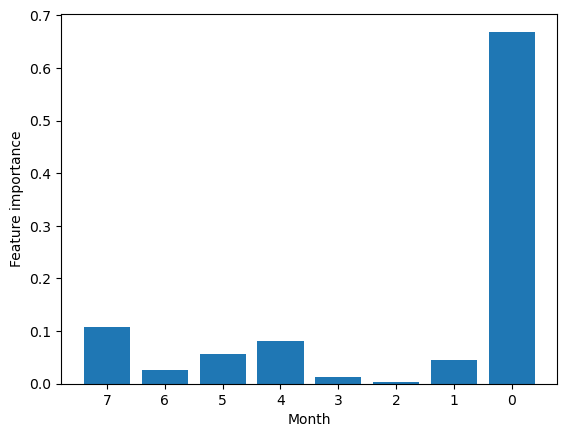

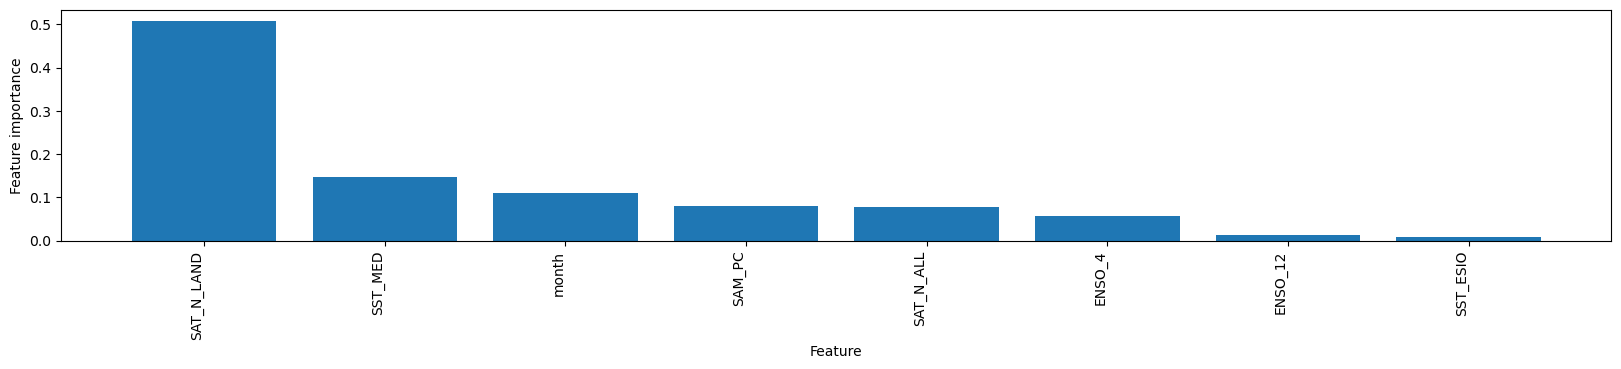

In [72]:
selection_lt0 = forward_selection(lead_time=0, seq_length=seq_length_0, settings=best_settings)

All feature performance: 0.26709154850561595
Selected feature performance: 0.2943339731450174
Selected features: ['PREC_SAHEL', 'SST_MED', 'month', 'ENSO_12', 'SOI', 'SSS_NA', 'ENSO_4', 'SSS_WNA', 'SAT_S_OCEAN']


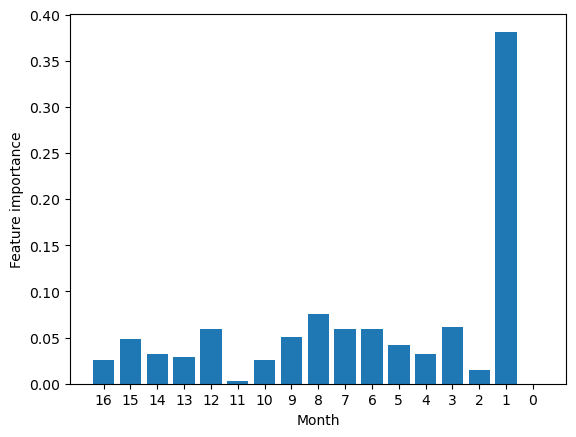

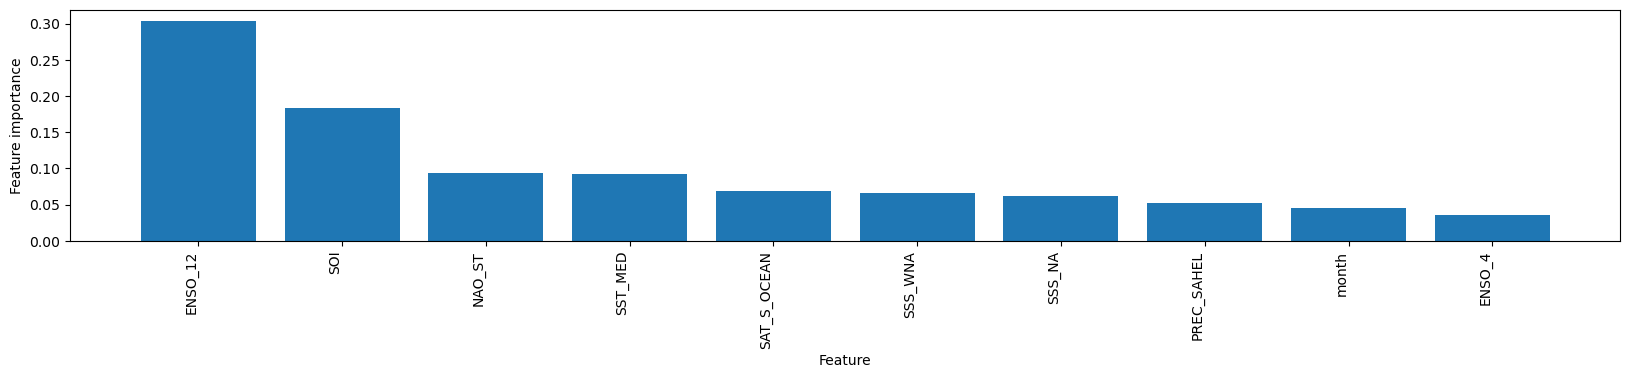

In [73]:
selection_lt1 = forward_selection(lead_time=1, seq_length=seq_length_1, settings=best_settings)

All feature performance: 0.16457133448015654
Selected feature performance: 0.16932129625672657
Selected features: ['month', 'ENSO_12', 'SOI', 'ENSO_34', 'SAT_S_LAND', 'ENSO_4', 'SAT_N_LAND', 'NP']


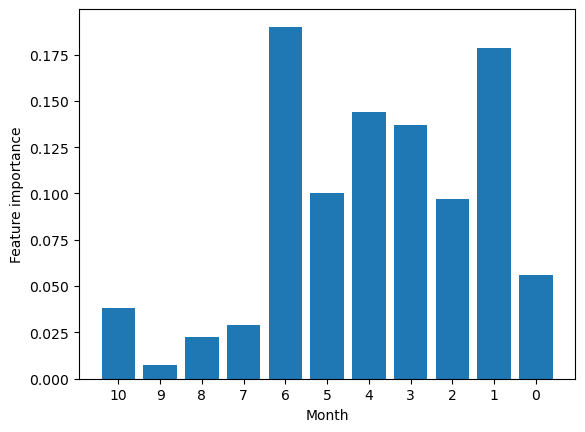

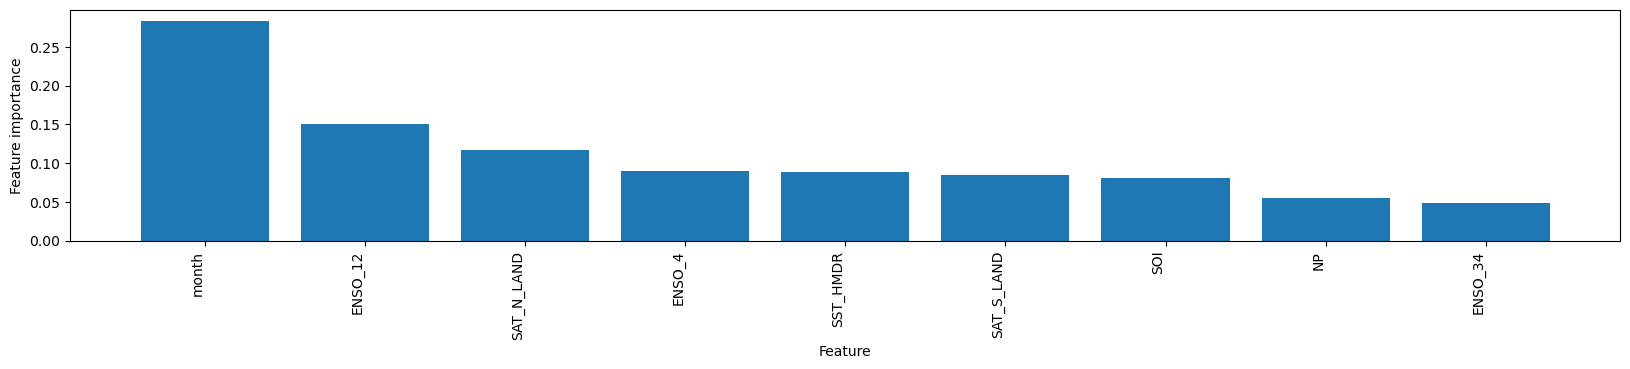

In [74]:
selection_lt3 = forward_selection(lead_time=3, seq_length=seq_length_3, settings=best_settings)

All feature performance: 0.14239875359036977
Selected feature performance: 0.17117844434515556
Selected features: ['month', 'SAT_S_LAND', 'SOI', 'ENSO_34', 'SAM_PC', 'SAM_ZM', 'SST_ESIO', 'ENSO_12', 'NAO_ST']


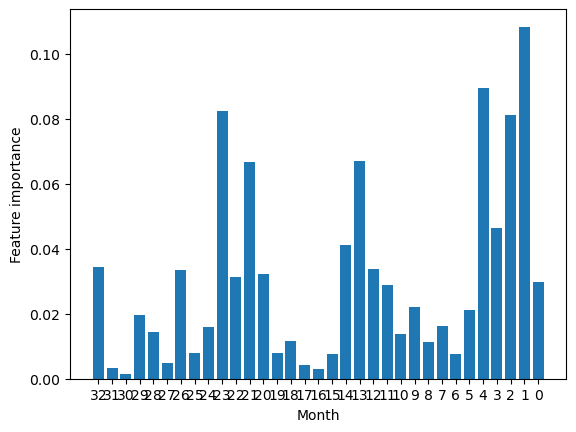

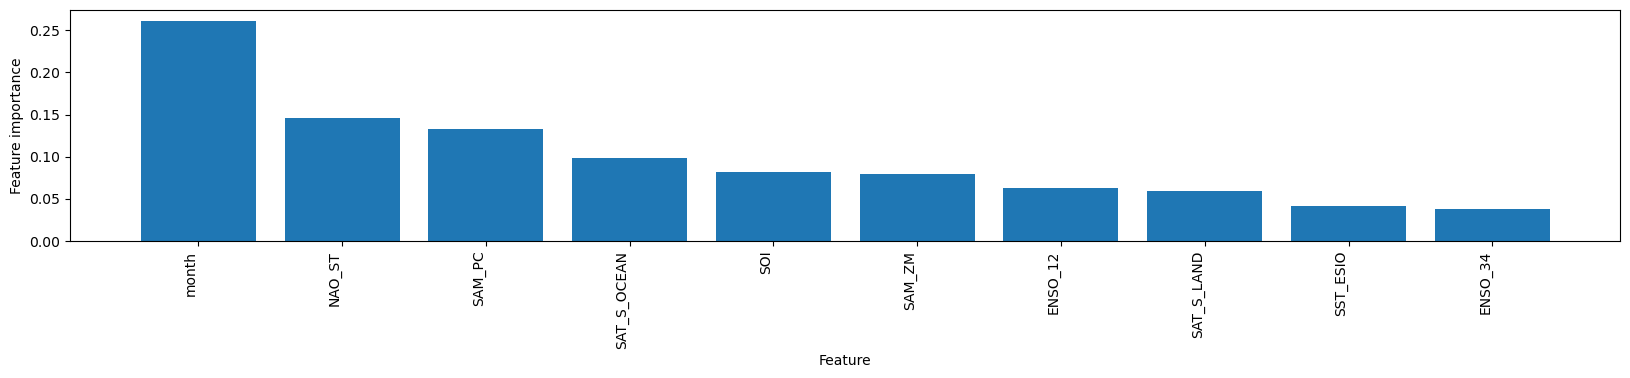

In [75]:
selection_lt6 = forward_selection(lead_time=6, seq_length=seq_length_6, settings=best_settings)

# Encoding

In [36]:
def find_best_encoding(settings, selected_features, seq_length, lead_time):
  encoding_options = ['normal', 'one_hot', 'one_hot_scaled']
  best_corr = float('-inf')
  best_encoding = None
  best_selection = None
    
  for encoding in encoding_options:
    # Adjust feature selection if needed, one hot encoded data has month_1,...,month_12 instead of month
    if encoding != 'normal' and selected_features != None and 'month' in selected_features:
        selection = ['month_{}'.format(i) for i in range(1,13)] + selected_features
        selection.remove('month')
    else: 
        selection = selected_features
    
    # Train model and get corr
    data = Data(lead_time=lead_time, seq_length=seq_length, feature_list=selection, month_encoding=encoding, flatten_seq=True)
    model = AdaBoostRegressor(**settings)
    _, corr =  train_and_evaluate_randomforest(model, data)
    
    # Test if current encoding is an improvement
    if corr > best_corr:
        best_corr = corr
        best_encoding = encoding
        best_selection = selection
    
    # Print out information about current encoding
    print('Encoding {} has CorrCoef of: {}'.format(encoding, corr))
    
  # Print results
  print('\nBest encoding is {} with {} CorrCoef'.format(best_encoding, best_corr))      
        
  # Return the best found encoding and selection
  
  return best_encoding, best_selection

In [37]:
encoding_lt0, selection_lt0 = find_best_encoding(best_settings, selection_lt0, seq_length=seq_length_0, lead_time=0)

Encoding normal has CorrCoef of: 0.48022987111810167
Encoding one_hot has CorrCoef of: 0.3798539735054497
Encoding one_hot_scaled has CorrCoef of: 0.36769708520207933

Best encoding is normal with 0.48022987111810167 CorrCoef


In [38]:
encoding_lt1, selection_lt1 = find_best_encoding(best_settings, selection_lt1, seq_length=seq_length_1, lead_time=1)

Encoding normal has CorrCoef of: 0.2932025106612477
Encoding one_hot has CorrCoef of: 0.27144107028740044
Encoding one_hot_scaled has CorrCoef of: 0.2610693671261531

Best encoding is normal with 0.2932025106612477 CorrCoef


In [39]:
encoding_lt3, selection_lt3 = find_best_encoding(best_settings, selection_lt3, seq_length=seq_length_3, lead_time=3)

Encoding normal has CorrCoef of: 0.16932129625672657
Encoding one_hot has CorrCoef of: 0.11168385811878889
Encoding one_hot_scaled has CorrCoef of: 0.12943451969892122

Best encoding is normal with 0.16932129625672657 CorrCoef


In [40]:
encoding_lt6, selection_lt6 = find_best_encoding(best_settings, selection_lt6, seq_length=seq_length_6, lead_time=6)

Encoding normal has CorrCoef of: 0.1934634602108269
Encoding one_hot has CorrCoef of: 0.15912788160584215
Encoding one_hot_scaled has CorrCoef of: 0.1844491818209125

Best encoding is normal with 0.1934634602108269 CorrCoef


# Final evaluation

In [76]:
final_dict = {'Name': [], 'lead time': [], 'MSE FOCI': [], 'MSE CESM': [], 'Corr FOCI': [], 'Corr CESM': []}
name = 'AdaBoostRegressor'

In [77]:
# Info about the model
print('RandomForest for leadtime=0')
print('Encoding: {}'.format(encoding_lt0))
print('Feature selection: {}'.format(selection_lt0))
print('Settings: {}'.format(best_settings))

# Evaluate
data = Data(lead_time=0, seq_length=seq_length_0, feature_list=selection_lt0, month_encoding=encoding_lt0, flatten_seq=True)
rf = AdaBoostRegressor(**best_settings)

mse_foci, corr_foci = train_and_evaluate_randomforest(rf, data, calc_with='test', dataset='FOCI')
mse_cesm, corr_cesm = train_and_evaluate_randomforest(rf, data, calc_with='test', dataset='CESM')

# Insert into dict
final_dict['Name'].append(name)
final_dict['lead time'].append(0)
final_dict['MSE FOCI'].append(mse_foci)
final_dict['MSE CESM'].append(mse_cesm)
final_dict['Corr FOCI'].append(corr_foci)
final_dict['Corr CESM'].append(corr_cesm)

RandomForest for leadtime=0
Encoding: normal
Feature selection: ['SAT_N_LAND', 'month', 'SST_MED', 'SAT_N_ALL', 'ENSO_12', 'SAM_PC', 'ENSO_4']
Settings: {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 1}


In [78]:
# Info about the model
print('RandomForest for leadtime=1')
print('Encoding: {}'.format(encoding_lt1))
print('Feature selection: {}'.format(selection_lt1))
print('Settings: {}'.format(best_settings))

# Evaluate
data = Data(lead_time=1, seq_length=seq_length_1, feature_list=selection_lt1, month_encoding=encoding_lt1, flatten_seq=True)
rf = AdaBoostRegressor(**best_settings)

mse_foci, corr_foci = train_and_evaluate_randomforest(rf, data, calc_with='test', dataset='FOCI')
mse_cesm, corr_cesm = train_and_evaluate_randomforest(rf, data, calc_with='test', dataset='CESM')

# Insert into dict
final_dict['Name'].append(name)
final_dict['lead time'].append(1)
final_dict['MSE FOCI'].append(mse_foci)
final_dict['MSE CESM'].append(mse_cesm)
final_dict['Corr FOCI'].append(corr_foci)
final_dict['Corr CESM'].append(corr_cesm)

RandomForest for leadtime=1
Encoding: normal
Feature selection: ['PREC_SAHEL', 'SST_MED', 'month', 'ENSO_12', 'SOI', 'SSS_NA', 'ENSO_4', 'SSS_WNA', 'SAT_S_OCEAN']
Settings: {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 1}


In [79]:
# Info about the model
print('RandomForest for leadtime=3')
print('Encoding: {}'.format(encoding_lt3))
print('Feature selection: {}'.format(selection_lt3))
print('Settings: {}'.format(best_settings))

# Evaluate
data = Data(lead_time=3, seq_length=seq_length_3, feature_list=selection_lt3, month_encoding=encoding_lt3, flatten_seq=True)
rf = AdaBoostRegressor(**best_settings)

mse_foci, corr_foci = train_and_evaluate_randomforest(rf, data, calc_with='test', dataset='FOCI')
mse_cesm, corr_cesm = train_and_evaluate_randomforest(rf, data, calc_with='test', dataset='CESM')

# Insert into dict
final_dict['Name'].append(name)
final_dict['lead time'].append(3)
final_dict['MSE FOCI'].append(mse_foci)
final_dict['MSE CESM'].append(mse_cesm)
final_dict['Corr FOCI'].append(corr_foci)
final_dict['Corr CESM'].append(corr_cesm)

RandomForest for leadtime=3
Encoding: normal
Feature selection: ['month', 'ENSO_12', 'SOI', 'ENSO_34', 'SAT_S_LAND', 'ENSO_4', 'SAT_N_LAND', 'NP']
Settings: {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 1}


In [80]:
# Info about the model
print('RandomForest for leadtime=6')
print('Encoding: {}'.format(encoding_lt6))
print('Feature selection: {}'.format(selection_lt6))
print('Settings: {}'.format(best_settings))

# Evaluate
data = Data(lead_time=6, seq_length=seq_length_6, feature_list=selection_lt6, month_encoding=encoding_lt6, flatten_seq=True)
rf = AdaBoostRegressor(**best_settings)

mse_foci, corr_foci = train_and_evaluate_randomforest(rf, data, calc_with='test', dataset='FOCI')
mse_cesm, corr_cesm = train_and_evaluate_randomforest(rf, data, calc_with='test', dataset='CESM')

# Insert into dict
final_dict['Name'].append(name)
final_dict['lead time'].append(6)
final_dict['MSE FOCI'].append(mse_foci)
final_dict['MSE CESM'].append(mse_cesm)
final_dict['Corr FOCI'].append(corr_foci)
final_dict['Corr CESM'].append(corr_cesm)

RandomForest for leadtime=6
Encoding: normal
Feature selection: ['month', 'SAT_S_LAND', 'SOI', 'ENSO_34', 'SAM_PC', 'SAM_ZM', 'SST_ESIO', 'ENSO_12', 'NAO_ST']
Settings: {'learning_rate': 0.1, 'n_estimators': 50, 'random_state': 1}


In [81]:
final_results = pd.DataFrame(data=final_dict)
display(final_results)

,Name,lead time,MSE FOCI,MSE CESM,Corr FOCI,Corr CESM
0,AdaBoostRegressor,0,0.677826,0.866353,0.408963,0.529024
1,AdaBoostRegressor,1,0.789830,0.993224,0.179221,0.378378
2,AdaBoostRegressor,3,0.819409,1.000884,0.037008,0.366087
3,AdaBoostRegressor,6,0.837887,1.058575,0.002212,0.292198
